In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# Principal Component Analysis

In [2]:
df = pd.read_csv("Hitters.csv")
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [3]:
num_cols = [col for col in df.columns if df[col].dtypes != "O" and "Salary" not in col]

df[num_cols].head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors
0,293,66,1,30,29,14,1,293,66,1,30,29,14,446,33,20
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4


In [4]:
df = df[num_cols]
df.dropna(inplace=True)
df.shape

(322, 16)

In [5]:
df = StandardScaler().fit_transform(df)

In [6]:
pca = PCA()
pca_fit = pca.fit_transform(df)

In [7]:
pca.explained_variance_ratio_

array([4.60378552e-01, 2.60398491e-01, 1.03388605e-01, 5.36902121e-02,
       4.20784091e-02, 2.96359092e-02, 1.57079101e-02, 1.13928108e-02,
       7.83230398e-03, 5.87669497e-03, 3.74765194e-03, 3.09384056e-03,
       1.55679403e-03, 8.59034766e-04, 2.86873704e-04, 7.59064046e-05])

In [8]:
np.cumsum(pca.explained_variance_ratio_)

array([0.46037855, 0.72077704, 0.82416565, 0.87785586, 0.91993427,
       0.94957018, 0.96527809, 0.9766709 , 0.9845032 , 0.9903799 ,
       0.99412755, 0.99722139, 0.99877819, 0.99963722, 0.99992409,
       1.        ])

# Optimal Number of Components

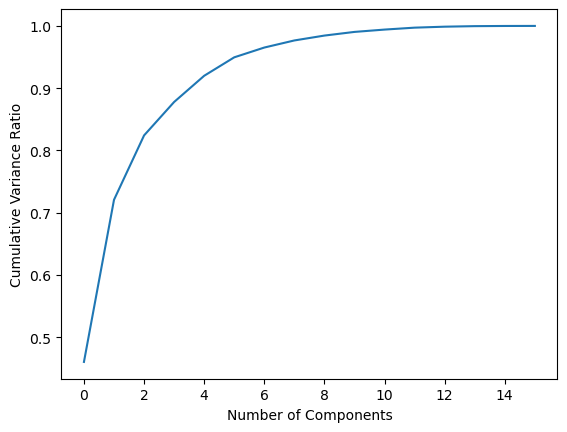

In [9]:
pca = PCA().fit(df)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Ratio")
plt.show()

# Creating the Final PCA.

In [10]:
pca = PCA(n_components=3)
pca_fit = pca.fit_transform(df)

pca.explained_variance_ratio_

array([0.46037855, 0.26039849, 0.1033886 ])

In [11]:
np.cumsum(pca.explained_variance_ratio_)

array([0.46037855, 0.72077704, 0.82416565])

# Principal Component Regression

In [12]:
df = pd.read_csv("Hitters.csv")
df.shape

(322, 20)

In [13]:
len(pca_fit)

322

In [14]:
num_cols = [col for col in df.columns if df[col].dtypes != "O" and "Salary" not in col]
len(num_cols)

16

In [15]:
others = [col for col in df.columns if col not in num_cols]

In [16]:
pd.DataFrame(pca_fit, columns=["PC1","PC2","PC3"]).head()

,PC1,PC2,PC3
0,-3.240106,-0.253173,0.776066
1,0.245488,1.302951,0.118040
2,0.603883,-2.617002,-0.698183
3,3.591276,0.547821,-1.049022
4,-2.264528,-0.698898,-1.290536


In [17]:
df[others].head()

,League,Division,Salary,NewLeague
0,A,E,NaN,A
1,N,W,475.0,N
2,A,W,480.0,A
3,N,E,500.0,N
4,N,E,91.5,N


In [18]:
final_df = pd.concat([pd.DataFrame(pca_fit, columns=["PC1","PC2","PC3"]),
                      df[others]], axis=1)

final_df.head()

,PC1,PC2,PC3,League,Division,Salary,NewLeague
0,-3.240106,-0.253173,0.776066,A,E,NaN,A
1,0.245488,1.302951,0.118040,N,W,475.0,N
2,0.603883,-2.617002,-0.698183,A,W,480.0,A
3,3.591276,0.547821,-1.049022,N,E,500.0,N
4,-2.264528,-0.698898,-1.290536,N,E,91.5,N


In [19]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [20]:
for col in ["NewLeague", "Division", "League"]:
    label_encoder(final_df, col)

In [21]:
final_df.dropna(inplace=True)

In [22]:
y = final_df["Salary"]
X = final_df.drop(["Salary"], axis=1)

In [23]:
lm = LinearRegression()
rmse = np.mean(np.sqrt(-cross_val_score(lm, X, y, cv=5, scoring="neg_mean_squared_error")))
print(rmse)
y.mean()

345.6021106351967


535.9258821292775

In [24]:
cart = DecisionTreeRegressor()
rmse = np.mean(np.sqrt(-cross_val_score(cart, X, y, cv=5, scoring="neg_mean_squared_error")))
print(rmse)

396.1162679751334


In [25]:
cart_params = {'max_depth': range(1, 11),
               "min_samples_split": range(2, 20)}

# GridSearchCV
cart_best_grid = GridSearchCV(cart,
                              cart_params,
                              cv=5,
                              n_jobs=-1,
                              verbose=True).fit(X, y)

cart_final = DecisionTreeRegressor(**cart_best_grid.best_params_, random_state=17).fit(X, y)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [26]:
rmse = np.mean(np.sqrt(-cross_val_score(cart_final, X, y, cv=5, scoring="neg_mean_squared_error")))
print(rmse)

330.1964109339104


# Visualizing High-Dimensional Data in 2D Using PCA

In [27]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

df = sns.load_dataset("iris")

y = df["species"]
X = df.drop(["species"], axis=1)

In [28]:
def create_pca_df(X, y):
    X = StandardScaler().fit_transform(X)
    pca = PCA(n_components=2)
    pca_fit = pca.fit_transform(X)
    pca_df = pd.DataFrame(data=pca_fit, columns=['PC1', 'PC2'])
    final_df = pd.concat([pca_df, pd.DataFrame(y)], axis=1)
    return final_df

In [29]:
pca_df = create_pca_df(X, y)

In [30]:
def plot_pca(dataframe, target):
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('PC1', fontsize=15)
    ax.set_ylabel('PC2', fontsize=15)
    ax.set_title(f'{target.capitalize()} ', fontsize=20)

    targets = list(dataframe[target].unique())
    colors = random.sample(['r', 'b', "g", "y"], len(targets))

    for t, color in zip(targets, colors):
        indices = dataframe[target] == t
        ax.scatter(dataframe.loc[indices, 'PC1'], dataframe.loc[indices, 'PC2'], c=color, s=50)
    ax.legend(targets)
    ax.grid()
    plt.show()

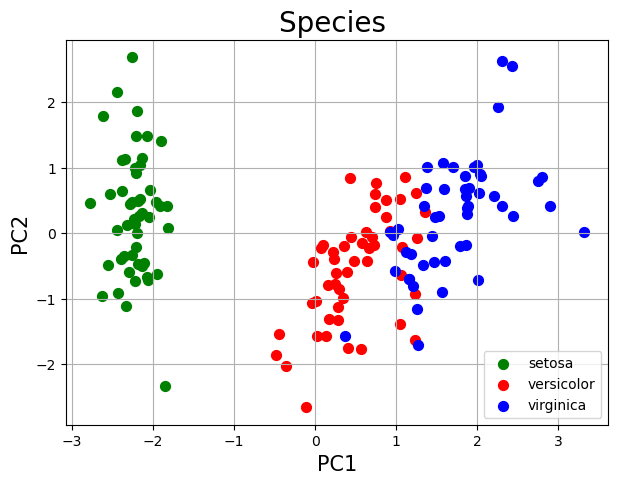

In [31]:
plot_pca(pca_df, "species")

# Diabetes

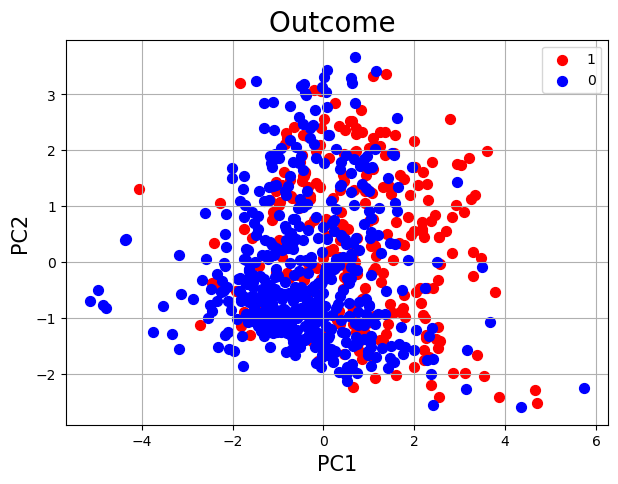

In [32]:
df = pd.read_csv("diabetes.csv")

y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

pca_df = create_pca_df(X, y)

plot_pca(pca_df, "Outcome")